In [3]:
# workaround if you have not yet installed CherenkovDeconvolution.py but want to try it from this notebook
import sys

sys.path.insert(0,'/net/nfshome/home/shaefs/CherenkovDeconvolution.py')

In [4]:
import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import tensorflow as tf
from sklearn import utils

import cherenkovdeconvolution as cd
import cherenkovdeconvolution.stepsize as stepsize

# Read in data

In [5]:
# Feature Selection
feature_list = ['SplineMPEDirectHitsICE.n_dir_doms', 
                        'VariousVariables.Cone_Angle',
                        'SplineMPECramerRaoParams.variance_theta',
                        'Borderness.Q_ratio_in_border',
                        'SplineMPETruncatedEnergy_SPICEMie_BINS_MuEres.value',
                        'SplineMPETruncatedEnergy_SPICEMie_DOMS_Neutrino.energy',
                        'SplineMPEDirectHitsICB.n_late_doms',
                        'Dustyness.n_doms_in_dust',
                        'LineFitGeoSplit1Params.n_hits',
                        'SplineMPEDirectHitsICC.dir_track_hit_distribution_smoothness',
                        'SPEFit2GeoSplit1BayesianFitParams.logl',
                        'SplineMPECharacteristicsIC.avg_dom_dist_q_tot_dom']
#feature_list = ['MCPrimary.energy']



In [6]:
# just read-in necessary columns
fields = feature_list + ['MCPrimary.energy']

In [7]:
# read in data
file_path = '/net/big-tank/POOL/users/lkardum/new_mc_binning.csv'
df_raw = pd.read_csv(file_path, skipinitialspace=True, usecols=fields)
df_raw

,SplineMPECramerRaoParams.variance_theta,SplineMPETruncatedEnergy_SPICEMie_DOMS_Neutrino.energy,MCPrimary.energy,SplineMPEDirectHitsICC.dir_track_hit_distribution_smoothness,SplineMPETruncatedEnergy_SPICEMie_BINS_MuEres.value,SplineMPECharacteristicsIC.avg_dom_dist_q_tot_dom,LineFitGeoSplit1Params.n_hits,SplineMPEDirectHitsICB.n_late_doms,SplineMPEDirectHitsICE.n_dir_doms,Borderness.Q_ratio_in_border,SPEFit2GeoSplit1BayesianFitParams.logl,Dustyness.n_doms_in_dust,VariousVariables.Cone_Angle
0,0.000138,20601.845970,3086.645078,-0.147665,0.397322,41.003142,19.0,34.0,20.0,0.101743,158.569898,0.175000,0.022686
1,0.003101,9461.487291,193.041166,0.344174,0.545559,50.324590,39.0,13.0,11.0,0.011322,272.450606,0.057143,0.097690
2,0.000325,43222.679757,862.503704,0.281681,0.463602,39.265226,21.0,20.0,17.0,0.618235,73.385557,0.217391,0.049914
3,0.000066,9929.465219,288.757353,0.222210,0.397322,16.576652,12.0,16.0,13.0,0.041282,81.277756,0.875000,0.023061
4,0.001243,14979.867844,1838.155763,-0.233723,0.545559,11.832243,16.0,16.0,13.0,0.979636,90.623889,0.294118,0.222784
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13336408,0.002613,28988.905556,2680.561232,-0.204343,0.545559,24.473264,5.0,13.0,11.0,0.000000,56.708233,0.000000,0.149460
13336409,0.000112,13010.699980,1695.794619,0.567237,0.342283,41.072783,110.0,58.0,23.0,0.002037,302.582772,0.555556,0.134817
13336410,0.010503,15232.377792,579.684909,0.317987,0.545559,45.828011,13.0,19.0,17.0,0.274274,108.338541,0.125000,0.090354
13336411,0.004765,19444.610677,205.607328,0.341417,0.545559,42.645669,13.0,12.0,8.0,0.000000,107.530913,0.000000,0.128185


In [8]:
# drop critical rows
df = df_raw.drop([ 1007671,  1426233,  2304853,  2715790,  3674355,  3741687, 4178063,  4969266,  5038333,  5334552,  5589516,  5863719,
 5978972,  7006367,  7281704,  7509650,  8380383,  8758113,9043798, 10280382, 11179530, 11184928, 11332586, 11797767,12253944], axis = 0)

# substitute NaNs with extreme Value
df.fillna(value =-100000, inplace = True)

# Discretize the target Neutrino Energy

In [9]:
# discretize
df['MCPrimary.energy'].describe()

count    1.333639e+07
mean     6.298949e+03
std      2.457562e+05
min      1.000001e+02
25%      2.706783e+02
50%      5.471676e+02
75%      1.416143e+03
max      9.970067e+07
Name: MCPrimary.energy, dtype: float64

In [10]:
# Variables: Label
# drop out all events with Energies outside the range
lower_limit = 100
upper_limit = 10**5

# Variables: NN
num_bins = 10 # number of bins (energy classes), output_shape

In [11]:
# throw out extreme high and low energy neutrinos
df = df[(df['MCPrimary.energy']<upper_limit) & (df['MCPrimary.energy']>lower_limit)]
df

,SplineMPECramerRaoParams.variance_theta,SplineMPETruncatedEnergy_SPICEMie_DOMS_Neutrino.energy,MCPrimary.energy,SplineMPEDirectHitsICC.dir_track_hit_distribution_smoothness,SplineMPETruncatedEnergy_SPICEMie_BINS_MuEres.value,SplineMPECharacteristicsIC.avg_dom_dist_q_tot_dom,LineFitGeoSplit1Params.n_hits,SplineMPEDirectHitsICB.n_late_doms,SplineMPEDirectHitsICE.n_dir_doms,Borderness.Q_ratio_in_border,SPEFit2GeoSplit1BayesianFitParams.logl,Dustyness.n_doms_in_dust,VariousVariables.Cone_Angle
0,0.000138,20601.845970,3086.645078,-0.147665,0.397322,41.003142,19.0,34.0,20.0,0.101743,158.569898,0.175000,0.022686
1,0.003101,9461.487291,193.041166,0.344174,0.545559,50.324590,39.0,13.0,11.0,0.011322,272.450606,0.057143,0.097690
2,0.000325,43222.679757,862.503704,0.281681,0.463602,39.265226,21.0,20.0,17.0,0.618235,73.385557,0.217391,0.049914
3,0.000066,9929.465219,288.757353,0.222210,0.397322,16.576652,12.0,16.0,13.0,0.041282,81.277756,0.875000,0.023061
4,0.001243,14979.867844,1838.155763,-0.233723,0.545559,11.832243,16.0,16.0,13.0,0.979636,90.623889,0.294118,0.222784
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13336408,0.002613,28988.905556,2680.561232,-0.204343,0.545559,24.473264,5.0,13.0,11.0,0.000000,56.708233,0.000000,0.149460
13336409,0.000112,13010.699980,1695.794619,0.567237,0.342283,41.072783,110.0,58.0,23.0,0.002037,302.582772,0.555556,0.134817
13336410,0.010503,15232.377792,579.684909,0.317987,0.545559,45.828011,13.0,19.0,17.0,0.274274,108.338541,0.125000,0.090354
13336411,0.004765,19444.610677,205.607328,0.341417,0.545559,42.645669,13.0,12.0,8.0,0.000000,107.530913,0.000000,0.128185


In [12]:
## log-scaled Binning
bins = np.logspace(np.log10(lower_limit), np.log10(upper_limit), num_bins+1)
bins

array([   100.        ,    199.5262315 ,    398.10717055,    794.32823472,
         1584.89319246,   3162.27766017,   6309.5734448 ,  12589.25411794,
        25118.8643151 ,  50118.72336273, 100000.        ])

In [13]:
# new column with discretized energies

df['E_discr'] = pd.cut(df['MCPrimary.energy'], bins=bins, labels=range(len(bins)-1))
df['E_discr'].value_counts()

1    3265825
2    2971469
3    2110752
0    1939697
4    1327291
5     776316
6     435447
7     239490
8     128030
9      67777
Name: E_discr, dtype: int64

# Create target dataset

In [14]:
X = df[feature_list].to_numpy()
X.shape

(13262094, 12)

In [15]:
y = df['E_discr'].to_numpy()
y.shape

(13262094,)

In [16]:
# subsample size

def create_dataset(X, y, subset=0, validation_split=0.3):
    # X,y: numpy Array
    # subset: size of the subset (Int)
    # validation_split: (0, 1) 
    perm = np.random.permutation(len(X))

    if subset:
        perm = perm[0:subset]

    limit = int(len(perm)*(1-validation_split))

    X_train = X[perm[:limit]]
    X_eval = X[perm[limit:]]
    y_train = y[perm[:limit]]
    y_eval = y[perm[limit:]]

    return X_train, y_train, X_eval, y_eval

In [17]:
X_train, y_train, X_eval, y_eval = create_dataset(X, y, validation_split=0.1, subset=None)
print(X_train.shape, y_train.shape, X_eval.shape, y_eval.shape)

(11935884, 12) (11935884,) (1326210, 12) (1326210,)


In [18]:
# reduce size of evaluation data
sample_size=500_000

In [19]:
# reduce size of test set
y_eval = y_eval[0:sample_size]
X_eval = X_eval[0:sample_size]
X_eval.shape, y_eval.shape

((500000, 12), (500000,))

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_eval = scaler.transform(X_eval)

# True distribution

In [21]:
_, f_true = np.unique(y_eval, return_counts=True)
f_true = f_true/len(y_eval)
f_true

array([0.147122, 0.246214, 0.224416, 0.15894 , 0.099776, 0.057786,
       0.032582, 0.018136, 0.00985 , 0.005178])

# Build Neural Network

In [22]:
# neural network
def make_model(num_features, num_classes, learning_rate=0.0005):

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(120, input_shape=num_features, activation='relu'))
    #model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(240, activation='relu'))
    #model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(120, activation='relu'))
    #model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(12, activation='relu'))
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

    # compile the NN
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss = tf.keras.losses.CategoricalCrossentropy()
    metric = tf.keras.metrics.CategoricalAccuracy(name="categorical_accuracy", dtype=None)

    model.compile(optimizer=opt, loss=loss, metrics=[metric])

    return model

# Define Classifier (Wrapper for DSEA/Sklearn)

In [23]:
class MyClassifier():
    def __init__(self, batch_size=2048, epochs=5, learning_rate=0.0005, one_model=False):
        """
        one_model: If True dsea will train only one model instead of generating a new one in each dsea iteration
        batchsize, epoch, learning_rate: model parameters
        """
        self.Niter = 0
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.model = None
        self.one_model = one_model
        self.history = [] # save model_history for each dsea iteration

    def fit(self, X, y, sample_weight=None):
        # print iteration num
        self.Niter += 1
        print(f'\nNumber iteration: {self.Niter}')

        """
        y is NOT one-hot encoded yet
        """
        y_hot = np.zeros((y.size, y.max()+1))
        y_hot[np.arange(y.size),y] = 1
        
        # create new model if (one_model=False) or (one_model = True and there exist no model yet)
        if self.model is None or self.one_model is False:
            self.model = make_model(num_features=(len(feature_list), ), num_classes=y.max()+1, learning_rate=self.learning_rate)
        print(type(self.model))
        history = self.model.fit(X, y_hot, sample_weight=sample_weight, batch_size=self.batch_size, epochs=self.epochs)
        self.history.append(history)

        return self
    
    def predict_proba(self, X):
        return self.model.predict(X)

    def get_model(self):
        return self.model

    def get_model_history(self):
        list_loss = []
        list_acc = []
        for history in self.history:
            list_loss += history.history['loss']
            list_acc += history.history['categorical_accuracy']
            
        list_loss = np.array(list_loss)
        list_acc = np.array(list_acc)

        return list_loss, list_acc

# Neural Network: Training

In [24]:
# need one hot encoded vector for softmax
y_train_hot = np.zeros((y_train.size, y_train.max()+1))
y_train_hot[np.arange(y_train.size),y_train] = 1

y_eval_hot = np.zeros((y_eval.size, y_eval.max()+1))
y_eval_hot[np.arange(y_eval.size),y_eval] = 1

In [22]:
model = make_model(num_features=(len(feature_list), ), num_classes=num_bins, learning_rate=0.0005)
model.fit(X_train, y_train_hot, batch_size=2048, epochs=3)

Train on 11995492 samples
Epoch 1/3
11995492/11995492 [==============================] - 26s 2us/sample - loss: 1.3046 - categorical_accuracy: 0.4598
Epoch 2/3
11995492/11995492 [==============================] - 25s 2us/sample - loss: 1.2778 - categorical_accuracy: 0.4698
Epoch 3/3
11995492/11995492 [==============================] - 25s 2us/sample - loss: 1.2729 - categorical_accuracy: 0.4719


In [23]:
model.save_weights('models/model_NN.h5')

# Neural Network: Evaluation with Bootstrap

In [ ]:
# variables for bootstrap (NN and DSEA)
npulls = 100
sample_size

500000

In [25]:
bootstrap_nn = np.ndarray(shape=(npulls,num_bins),dtype=float)

for i in range(npulls):
    if i%1 ==0:
        print(i+1,' of ', npulls)
    
    # create random subsample of the evaluation data
    X_eval_bst, y_hot = utils.resample(X_eval, y_eval_hot, replace=True, n_samples=sample_size, random_state=i)# bootstrap random sample from X_test

    # predict subsample
    y_pred_temp = model.predict(X_eval_bst)

    # save f_pred for each evaluation subsample
    bootstrap_nn[i,:] = y_pred_temp.sum(axis=0)

1  of  100
2  of  100
3  of  100
4  of  100
5  of  100
6  of  100
7  of  100
8  of  100
9  of  100
10  of  100
11  of  100
12  of  100
13  of  100
14  of  100
15  of  100
16  of  100
17  of  100
18  of  100
19  of  100
20  of  100
21  of  100
22  of  100
23  of  100
24  of  100
25  of  100
26  of  100
27  of  100
28  of  100
29  of  100
30  of  100
31  of  100
32  of  100
33  of  100
34  of  100
35  of  100
36  of  100
37  of  100
38  of  100
39  of  100
40  of  100
41  of  100
42  of  100
43  of  100
44  of  100
45  of  100
46  of  100
47  of  100
48  of  100
49  of  100
50  of  100
51  of  100
52  of  100
53  of  100
54  of  100
55  of  100
56  of  100
57  of  100
58  of  100
59  of  100
60  of  100
61  of  100
62  of  100
63  of  100
64  of  100
65  of  100
66  of  100
67  of  100
68  of  100
69  of  100
70  of  100
71  of  100
72  of  100
73  of  100
74  of  100
75  of  100
76  of  100
77  of  100
78  of  100
79  of  100
80  of  100
81  of  100
82  of  100
83  of  100
84  of  100
8

In [26]:
import seaborn as sns

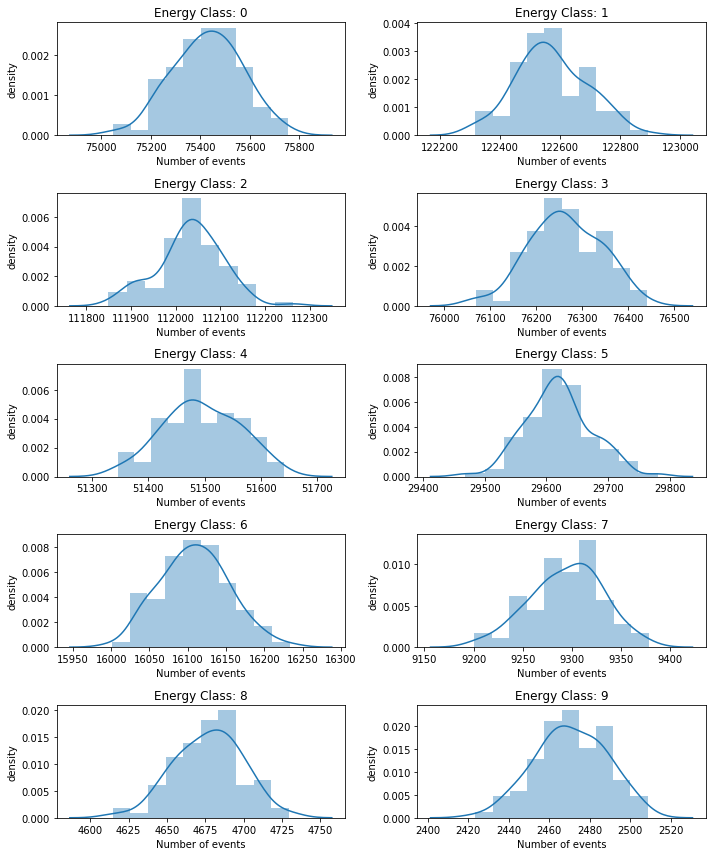

In [27]:
fig, axs = plt.subplots(5,2, figsize=(10,12))
for i in range(5):
    for j in range(2):
        sns.distplot(bootstrap_nn[:,2*i+j], bins=10, ax=axs[i,j])
        axs[i,j].set_xlabel('Number of events')
        axs[i,j].set_ylabel('density')

        axs[i,j].set_title(f'Energy Class: {2*i+j}')

plt.tight_layout()
plt.savefig('output/bootstrap_nn_dist.pdf')

In [28]:
f_nn = bootstrap_nn.mean(axis=0)
f_nn_norm = f_nn/f_nn.sum()
f_nn_norm

array([0.15086918, 0.24516135, 0.22408175, 0.152538  , 0.10299743,
       0.05924418, 0.03222046, 0.01859109, 0.00935487, 0.0049417 ])

In [29]:
f_nn_std = bootstrap_nn.std(axis=0)/f_nn.sum()
f_nn_std

array([2.76340899e-04, 2.34717788e-04, 1.44568463e-04, 1.54679756e-04,
       1.34171274e-04, 1.06700869e-04, 8.85921308e-05, 7.31346956e-05,
       4.39255402e-05, 3.48243745e-05])

# DSEA: Training

In [23]:
a = 0.75
b = 2

In [24]:
# first of all, we set up an inspection function, which prints the step size of each iteration
def inspect_alpha(k, alpha, chi2s, f): # you can define custom inspection methods to investigate DSEA
    print(alpha)

In [25]:
alpha_exp = stepsize.decay_exp(a, b) # start with step size 2

In [25]:
cf = MyClassifier(batch_size=2048, epochs=10, learning_rate=0.0005, one_model=True)

In [26]:
f_est = cd.dsea(X_eval, X_train, y_train, cf, K=3, ) #, inspect = inspect_alpha,  alpha = alpha_exp
f_est


Number iteration: 1
[0.0144726  0.01028054 0.01028054 ... 0.00935339 0.01575585 0.01575585] @@@@@@@@
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
Train on 11935884 samples
Epoch 1/10
 1392640/11935884 [==>...........................] - ETA: 43s - loss: 0.0440 - categorical_accuracy: 0.3071

KeyboardInterrupt: 

In [28]:
# predict evaluation data
model_dsea = cf.get_model()
#y_eval_dsea = model_dsea.predict(X_eval)

In [29]:
model_dsea.save_weights(f'models/dsea_exp_75e-2_2_{num_bins}bins_3it_10ep.h5')

In [34]:
# get model without stepsize
model_old = make_model(num_features=(len(feature_list), ), num_classes=num_bins, learning_rate=0.0005)
model_old.load_weights('gridsearch_results/one_model_True/models/8it_10ep.h5')

In [35]:
y_old = model_old.predict(X_eval)

array([0.15943339, 0.2283458 , 0.21190242, 0.15888866, 0.10953663,
       0.06093257, 0.03475735, 0.01887446, 0.01022084, 0.00703026])

In [36]:
#f_dsea = y_eval_dsea.sum(axis=0)/len(y_eval_dsea)
#f_dsea

In [37]:
list_loss, list_acc = cf.get_model_history()
list_loss.shape, list_acc.shape

((120,), (120,))

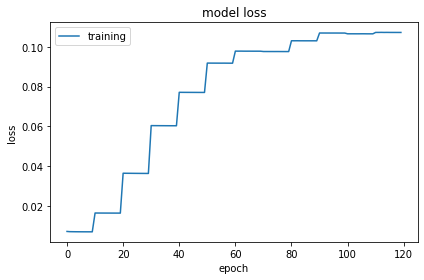

In [38]:
# plot loss per epochs

plt.plot(list_loss)
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])
plt.tight_layout()
plt.show()

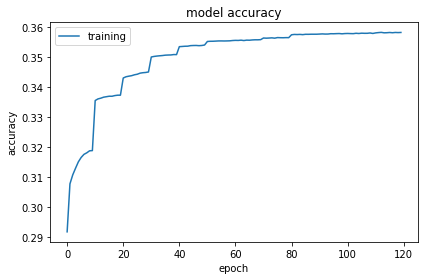

In [39]:
# plot accuracy per epochs

plt.plot(list_acc)
#plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])
plt.tight_layout()
plt.show()

# DSEA: Evaluation with Bootstrap

In [40]:
bootstrap_dsea = np.ndarray(shape=(npulls,num_bins),dtype=float)

for i in range(npulls):
    if i%1 ==0:
        print(i,' of ', npulls)
    
    # create random subsample of the evaluation data
    X_eval_bst, y_hot = utils.resample(X_eval, y_eval_hot, replace=True, n_samples=sample_size, random_state=i)# bootstrap random sample from X_test

    # predict subsample
    y_pred_temp = model_dsea.predict(X_eval_bst)

    # save f_pred for each evaluation subsample
    bootstrap_dsea[i,:] = y_pred_temp.sum(axis=0)

0  of  100
1  of  100
2  of  100
3  of  100
4  of  100
5  of  100
6  of  100
7  of  100
8  of  100
9  of  100
10  of  100
11  of  100
12  of  100
13  of  100
14  of  100
15  of  100
16  of  100
17  of  100
18  of  100
19  of  100
20  of  100
21  of  100
22  of  100
23  of  100
24  of  100
25  of  100
26  of  100
27  of  100
28  of  100
29  of  100
30  of  100
31  of  100
32  of  100
33  of  100
34  of  100
35  of  100
36  of  100
37  of  100
38  of  100
39  of  100
40  of  100
41  of  100
42  of  100
43  of  100
44  of  100
45  of  100
46  of  100
47  of  100
48  of  100
49  of  100
50  of  100
51  of  100
52  of  100
53  of  100
54  of  100
55  of  100
56  of  100
57  of  100
58  of  100
59  of  100
60  of  100
61  of  100
62  of  100
63  of  100
64  of  100
65  of  100
66  of  100
67  of  100
68  of  100
69  of  100
70  of  100
71  of  100
72  of  100
73  of  100
74  of  100
75  of  100
76  of  100
77  of  100
78  of  100
79  of  100
80  of  100
81  of  100
82  of  100
83  of  100
84

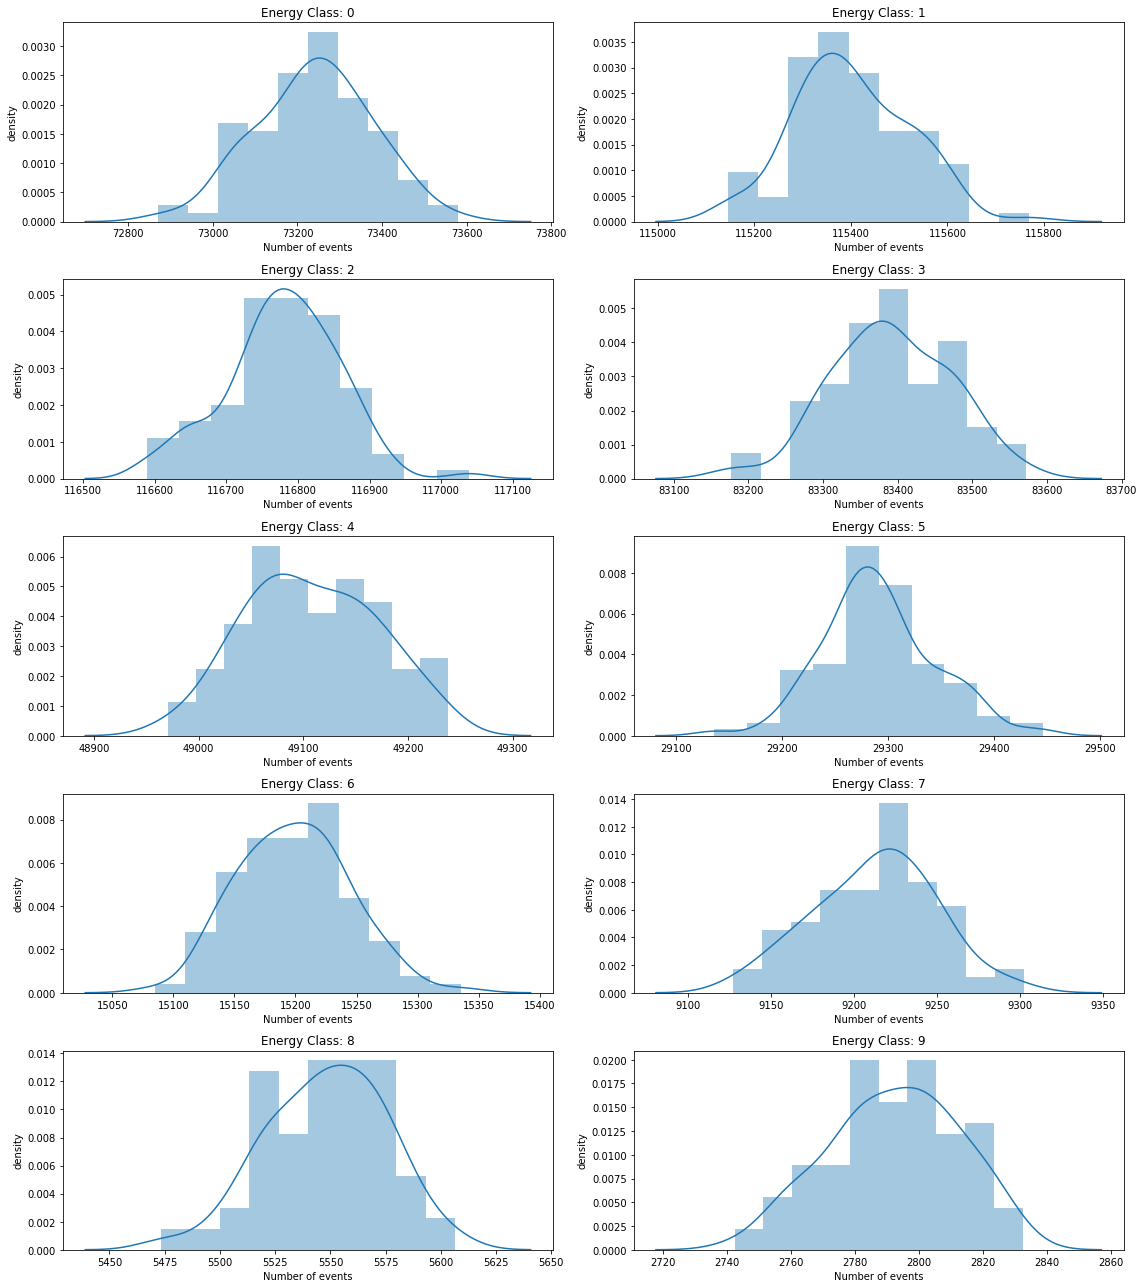

In [41]:
fig, axs = plt.subplots(5,2, figsize=(16,18))
for i in range(5):
    for j in range(2):
        sns.distplot(bootstrap_dsea[:,2*i+j], bins=10, ax=axs[i,j])
        axs[i,j].set_xlabel('Number of events')
        axs[i,j].set_ylabel('density')

        axs[i,j].set_title(f'Energy Class: {2*i+j}')

plt.tight_layout()
plt.savefig('output/bootstrap_dsea_dist.pdf')

In [42]:
f_dsea = bootstrap_dsea.mean(axis=0)
f_dsea_norm = f_dsea/f_dsea.sum()
f_dsea_norm

array([0.1464906 , 0.23082069, 0.23357585, 0.16679491, 0.09822305,
       0.05858633, 0.03040017, 0.01842613, 0.01109705, 0.00558522])

In [43]:
f_dsea_std = bootstrap_dsea.std(axis=0)/f_dsea.sum()
f_dsea_std

array([2.72084726e-04, 2.35339665e-04, 1.57822916e-04, 1.58531983e-04,
       1.24304122e-04, 1.06456397e-04, 8.95257122e-05, 7.30058310e-05,
       5.38903344e-05, 4.02772910e-05])

# Compare NN, DSEA and true distribution

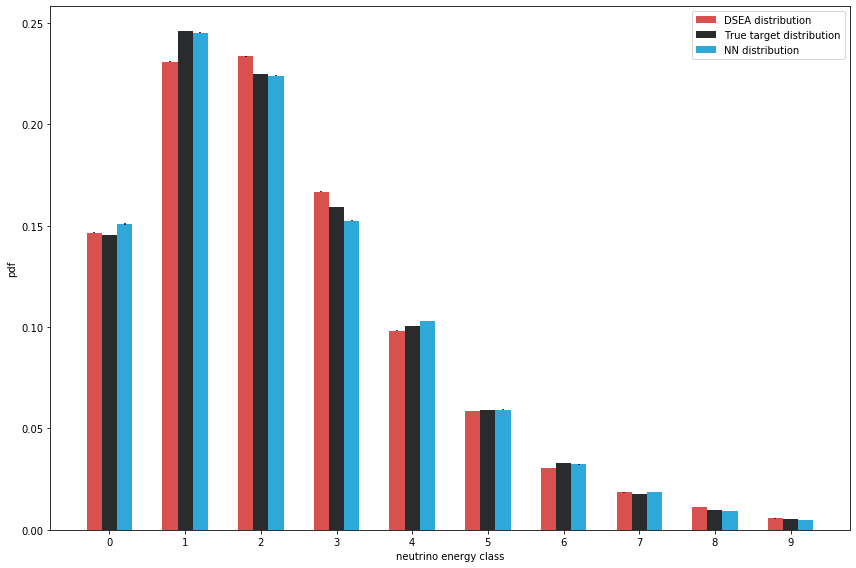

In [45]:
%matplotlib inline

# prepare plot
fig, ax = plt.subplots(figsize=(12,8))
index = np.arange(10)
barwidth = .2
barwidth2 = .6


# add bar plots
ax.bar(index-barwidth/2,           f_dsea_norm,  barwidth, yerr=f_dsea_std, label='DSEA distribution', color='#D9514EFF') #royalblue
ax.bar(index+barwidth/2, f_true, barwidth, label='True target distribution', color='#2A2B2DFF') # #26a55b
ax.bar(index+barwidth*3/2, f_nn_norm, barwidth, yerr=f_nn_std, label='NN distribution', color='#2DA8D8FF') # #ff5733
ax.legend()

# show plot
plt.xticks(index + barwidth / 2, range(10))
plt.xlabel('neutrino energy class')
plt.ylabel('pdf')

plt.tight_layout()
plt.savefig('output/pdf_classes_dsea_nn.png')
plt.show()

In [31]:
# centers of the bin limits (size reduced by 1)
bin_centers = np.array([(bins[i] + (bins[i+1]-bins[i])/2) for i in range(len(bins)-1)])

In [32]:
bin_width = np.array([bins[i+1]-bins[i] for i in range(num_bins)])
bin_width

array([   99.5262315 ,   198.58093906,   396.22106417,   790.56495774,
        1577.38446771,  3147.29578463,  6279.68067314, 12529.61019715,
       24999.85904763, 49881.27663727])

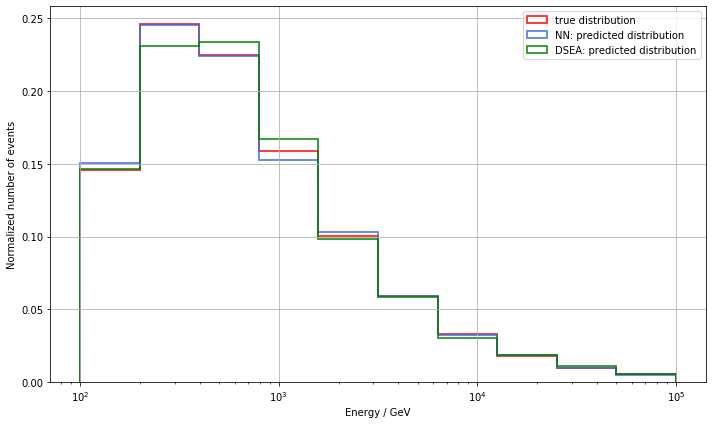

In [47]:
fig1, ax1 = plt.subplots(figsize=(10, 6))

ax1.hist(bin_centers, bins=bins, weights=f_true, alpha=0.8, color='red', histtype='step', linewidth=1.9, label='true distribution')
ax1.hist(bin_centers, bins=bins, weights=f_nn_norm, alpha=0.8, color='royalblue', histtype='step', linewidth=1.9, label='NN: predicted distribution')
ax1.hist(bin_centers, bins=bins, weights=f_dsea_norm, alpha=0.8, color='green', histtype='step', linewidth=1.9, label='DSEA: predicted distribution')


#ax1.hist(y_pred_sum_energy, bins=bins, alpha=0.8, color='royalblue', histtype='step', linewidth=1.4, label='predicted_sum')
#ax1.hist(y_pred_energy, bins=bins, alpha=0.8, color='green', histtype='step', linewidth=1.4, label='predicted_max')


ax1.set_xscale('log')
#ax1.set_xticks(bin_centers)
#ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_xlabel(r'Energy / GeV')

ax1.set_ylabel('Normalized number of events')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('output/spectrum_comparison.pdf')
plt.show()

In [1]:
fig = plt.figure(figsize=(6.4,4.8),dpi=200) #dpi 300 for full hd
fig.tight_layout()

# seperation DSEA plot and ratio
gs = matplotlib.gridspec.GridSpec(4, 1)
axes1 = fig.add_subplot(gs[:-1])
axes2 = fig.add_subplot(gs[-1], sharex=axes1)
fig.subplots_adjust(hspace = .001)

# spectrum
axes1.errorbar(bin_centers, f_true, fmt='r_', xerr=bin_width/2, elinewidth=0.8, label='true distribution') #true distr
axes1.errorbar(bin_centers, f_dsea_norm, fmt='b_', xerr=bin_width/2, yerr=f_dsea_std, elinewidth=0.8, label='pred. distribution') #pred. distr
axes1.set_xscale('log')

# ratio
axes2.errorbar(bin_centers, f_dsea_norm/f_true, fmt='k_', xerr=bin_width/2, yerr=f_dsea_std/f_true, elinewidth=0.8,)
axes2.set_xscale('log')

NameError: name 'plt' is not defined

In [114]:
# release gpu memory
from numba import cuda 

device = cuda.get_current_device()
device.reset()

# Compare dsea prediction with exp. stepsize and with default

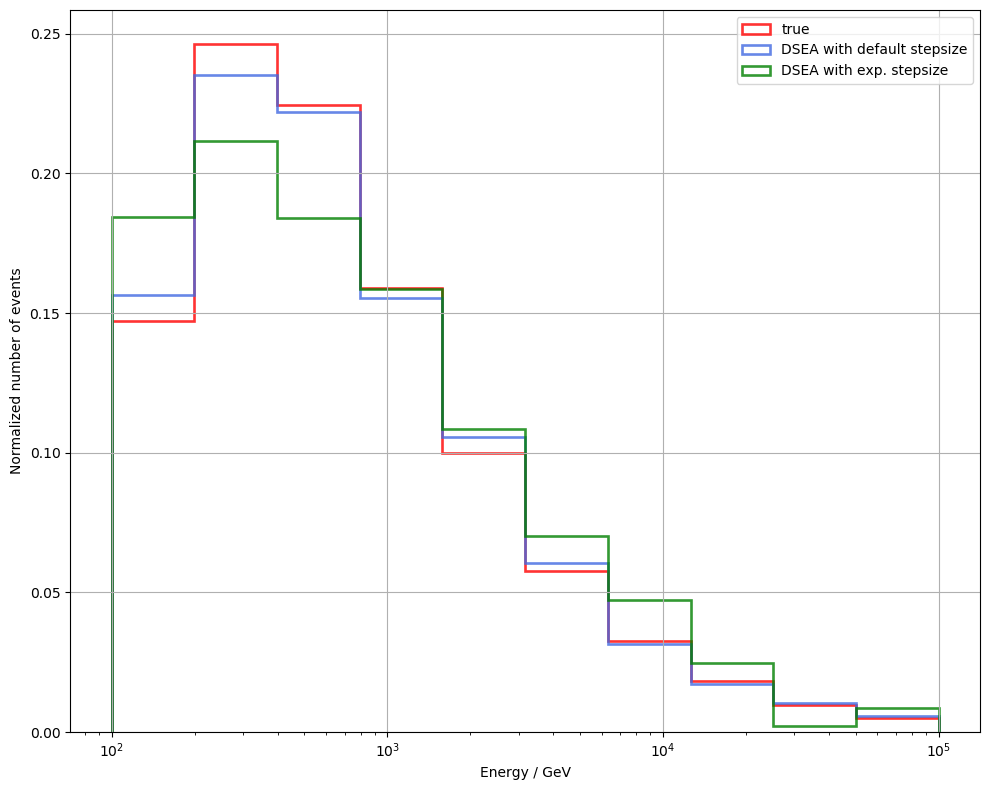

In [37]:
#plt.figure(figsize=(10,8))
#plt.hist(np.arange(num_bins), weights=f_est, histtype='step', label='estimated with exp. stepsize')
#plt.hist(np.arange(num_bins), weights=, histtype='step', label='estimated with default stepsize')
#plt.hist(np.arange(num_bins), weights=f_true, histtype='step', label='true')

fig1, ax1 = plt.subplots(figsize=(10, 8), dpi=100)

ax1.hist(bin_centers, bins=bins, weights=f_true, alpha=0.8, color='red', histtype='step', linewidth=1.9, label='true')
ax1.hist(bin_centers, bins=bins, weights=y_old.sum(axis=0)/len(y_old), alpha=0.8, color='royalblue', histtype='step', linewidth=1.9, label='DSEA with default stepsize')
ax1.hist(bin_centers, bins=bins, weights=f_est, alpha=0.8, color='green', histtype='step', linewidth=1.9, label='DSEA with exp. stepsize')


#ax1.hist(y_pred_sum_energy, bins=bins, alpha=0.8, color='royalblue', histtype='step', linewidth=1.4, label='predicted_sum')
#ax1.hist(y_pred_energy, bins=bins, alpha=0.8, color='green', histtype='step', linewidth=1.4, label='predicted_max')


ax1.set_xscale('log')
#ax1.set_xticks(bin_centers)
#ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_xlabel(r'Energy / GeV')

ax1.set_ylabel('Normalized number of events')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig('output/spectrum_comparison.pdf')
plt.show()